In [66]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train_clean.csv')
test = pd.read_csv('/Users/siero5335/channel/test_clean.csv')


sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

In [67]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=10000):

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    print(norm_low_cutoff)
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    sigma = (1/0.6745) * maddest( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    return pywt.waverec( coeff, wavelet, mode='per' )

train['signal_wave'] = denoise_signal(train['signal'])
test['signal_wave'] = denoise_signal(test['signal'])

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

train['signal_FFT_1e5'] = filter_signal(train['signal'], threshold=5e3)
test['signal_FFT_1e5'] = filter_signal(test['signal'], threshold=5e3)

In [68]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [69]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [70]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p5(x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95( x : pd.Series) -> pd.Series : return x.quantile(0.95)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

zscore = lambda x: (x - x.mean()) / x.std()

In [71]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df


def generate_features(data: pd.DataFrame,
                      batch_sizes: list,
                      window_sizes: list) -> pd.DataFrame:
    """
    Generate features for https://www.kaggle.com/c/liverpool-ion-switching

    Generate various aggregations over the data.

    Args:
        window_sizes: window sizes for rolling features
        batch_sizes: batch sizes for which features are aggregated
        data: original dataframe

    Returns:
        dataframe with generated features
    """
    for batch_size in batch_sizes:
        data['batch'] = ((data['time'] * 10_000) - 1) // batch_size
        data['batch_index'] = ((data['time'] * 10_000) - 1) - (data['batch'] * batch_size)
        data['batch_slices'] = data['batch_index'] // (batch_size / 10)
        data['batch_slices2'] = data['batch'].astype(str).str.zfill(3) + '_' + data['batch_slices'].astype(
            str).str.zfill(3)

        for agg_feature in ['batch', 'batch_slices2']:
            data[f"min_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('min')
            data[f"max_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('max')
            data[f"std_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('std')
            data[f"mean_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('mean')
            
            data[f"q1_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p1(x))    
            data[f"q5_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p5(x))      
            data[f"q95_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p95(x))   
            data[f"q99_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p99(x))                   
        
            data[f"zscore_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform(zscore)
            data[f"perm_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:perm_entropy(x))
            data[f" higuchi_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:higuchi_fd(x))
            data[f" katz_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:katz_fd(x))

            data[f"mean_abs_chg_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.mean(np.abs(np.diff(x))))
            data[f"abs_max_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.max(np.abs(x)))
            data[f"abs_min_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.min(np.abs(x)))

            data[f"min_{agg_feature}_{batch_size}_diff"] = data[f"min_{agg_feature}_{batch_size}"] - data['signal']
            data[f"max_{agg_feature}_{batch_size}_diff"] = data[f"max_{agg_feature}_{batch_size}"] - data['signal']
            data[f"std_{agg_feature}_{batch_size}_diff"] = data[f"std_{agg_feature}_{batch_size}"] - data['signal']
            data[f"mean_{agg_feature}_{batch_size}_diff"] = data[f"mean_{agg_feature}_{batch_size}"] - data['signal']

            data[f"range_{agg_feature}_{batch_size}"] = data[f"max_{agg_feature}_{batch_size}"] - data[
                f"min_{agg_feature}_{batch_size}"]
            data[f"maxtomin_{agg_feature}_{batch_size}"] = data[f"max_{agg_feature}_{batch_size}"] / data[
                f"min_{agg_feature}_{batch_size}"]
            data[f"abs_avg_{agg_feature}_{batch_size}"] = (data[f"abs_min_{agg_feature}_{batch_size}"] + data[
                f"abs_max_{agg_feature}_{batch_size}"]) / 2
            
            
            data[f"q1_{agg_feature}_{batch_size}_diff"] = data[f"q1_{agg_feature}_{batch_size}"] - data['signal']   
            data[f"q5_{agg_feature}_{batch_size}_diff"] = data[f"q5_{agg_feature}_{batch_size}"] - data['signal'] 
            data[f"q95_{agg_feature}_{batch_size}_diff"] = data[f"q95_{agg_feature}_{batch_size}"] - data['signal']
            data[f"q99_{agg_feature}_{batch_size}_diff"] = data[f"q99_{agg_feature}_{batch_size}"] - data['signal']            
        
            data[f"zscore_{agg_feature}_{batch_size}_diff"] = data[f"zscore_{agg_feature}_{batch_size}"] - data['signal']
            data[f"perm_{agg_feature}_{batch_size}_diff"] = data[f"perm_{agg_feature}_{batch_size}"] - data['signal']
            data[f" higuchi_{agg_feature}_{batch_size}_diff"] = data[f" higuchi_{agg_feature}_{batch_size}"] - data['signal']
            data[f" katz_{agg_feature}_{batch_size}_diff"] = data[f" katz_{agg_feature}_{batch_size}"] - data['signal']

            data[f'signal_shift+1_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(1)['signal']
            data[f'signal_shift-1_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(-1)['signal']
            data[f'signal_shift+2_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(2)['signal']
            data[f'signal_shift-2_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(-2)['signal']

            data[f"signal_shift+1_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift+1_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift-1_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift-1_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift+2_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift+2_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift-2_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift-2_{agg_feature}_{batch_size}"] - data['signal']

        for window in window_sizes:
            window = min(batch_size, window)

            data["rolling_mean_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
            data["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
            data["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
            data["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']

            data[f'exp_Moving__{window}_{batch_size}'] = data.groupby('batch')['signal'].apply(
                lambda x: x.ewm(alpha=0.5, adjust=False).mean())
        data = reduce_mem_usage(data)
    data.fillna(0, inplace=True)

    return data

train_y = train['open_channels']

In [72]:
train.head()

,time,signal,open_channels,signal_wave,signal_FFT_1e5
0,0.0001,-2.7600,0,-2.49762507,0.39550089
1,0.0002,-2.8557,0,-3.54625102,0.39525892
2,0.0003,-2.4074,0,-0.95130824,0.39501695
3,0.0004,-3.1404,0,-1.32677506,0.39477497
4,0.0005,-3.1525,0,-3.60694965,0.39453300


In [73]:
test.head()

,time,signal,signal_wave,signal_FFT_1e5
0,500.0001,-2.67534728,-2.71852097,-2.70441365
1,500.0002,-2.87497894,-2.71851318,-2.70441890
2,500.0003,-2.88561059,-2.71850532,-2.70442414
3,500.0004,-2.46064224,-2.71849785,-2.70442937
4,500.0005,-2.64117389,-2.71849081,-2.70443461


In [74]:
#train.to_csv('/Users/siero5335/channel/train_mod.csv')
#test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [75]:
batch_sizes = [5000, 25000, 50000]
window_sizes = [5, 10, 50, 100, 500, 1000, 5000]

train = generate_features(train, batch_sizes, window_sizes)
test = generate_features(test, batch_sizes, window_sizes)

gc.collect()

Mem. usage decreased to 1711.85 Mb (62.6% reduction)
Mem. usage decreased to 3342.63 Mb (30.8% reduction)
Mem. usage decreased to 4973.41 Mb (23.0% reduction)
Mem. usage decreased to 671.39 Mb (63.0% reduction)
Mem. usage decreased to 1323.70 Mb (31.0% reduction)
Mem. usage decreased to 1976.01 Mb (23.1% reduction)


0

In [76]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [77]:
from sklearn import model_selection
train_features, valid_features, train_labels, valid_labels = model_selection.train_test_split(train, train_y, test_size=0.2)

In [78]:
trains = lgb.Dataset(train_features, train_labels)
valids = lgb.Dataset(valid_features, valid_labels)

In [79]:
params = {
    'learning_rate': 0.3, 
    'metric': 'l1',
    'bagging_fraction': 1.0,
    'bagging_freq': 0
}
best_params, history = {}, []
model = lgbopt.train(params, trains, valid_sets=valids,
                    verbose_eval=False,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    best_params=best_params,
                    tuning_history=history)

tune_num_leaves, val_score: 0.048086: 100%|##########| 20/20 [31:50<00:00, 95.54s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.048086:  10%|#         | 1/10 [01:38<14:42, 98.10s/it][I 2020-03-15 19:38:04,152] Finished trial#0 resulted in value: 0.04822529895293906. Current best value is 0.04822529895293906 with parameters: {'bagging_fraction': 0.717623810494388, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.048086:  20%|##        | 2/10 [03:25<13:26, 100.80s/it][I 2020-03-15 19:39:51,282] Finished trial#1 resulted in value: 0.04827060579669429. Current best value is 0.04822529895293906 with parameters: {'bagging_fraction': 0.717623810494388, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.048086:  30%|###       | 3/10 [04:21<10:13, 87.59s/it] [I 2020-03-15 19:40:47,949] Finished trial#2 resulted in value: 0.04866362868066913. Current best value is 0.04822529895293906 with parameters: {'bagging_fraction': 0.717623810494388,

In [80]:
best_params

{'lambda_l1': 2.0399713962649173,
 'lambda_l2': 2.8178261577923572e-08,
 'num_leaves': 253,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [81]:
best_params.update(learning_rate = 0.01, bagging_fraction = 1.0, bagging_freq = 0,  metric = 'mae', random_state= 71, n_jobs=-1)

In [82]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = best_params

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=100)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Sun Mar 15 20:28:22 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.808641	valid_1's l1: 0.808664
[200]	training's l1: 0.307882	valid_1's l1: 0.308065
[300]	training's l1: 0.134464	valid_1's l1: 0.134886
[400]	training's l1: 0.0752747	valid_1's l1: 0.0758683
[500]	training's l1: 0.0555578	valid_1's l1: 0.0563004
[600]	training's l1: 0.0492392	valid_1's l1: 0.0501241
[700]	training's l1: 0.0472265	valid_1's l1: 0.0482512
[800]	training's l1: 0.0465331	valid_1's l1: 0.0476926
[900]	training's l1: 0.046231	valid_1's l1: 0.0475198
[1000]	training's l1: 0.0460494	valid_1's l1: 0.0474636
[1100]	training's l1: 0.045898	valid_1's l1: 0.0474284
[1200]	training's l1: 0.0457619	valid_1's l1: 0.0474049
[1300]	training's l1: 0.0456377	valid_1's l1: 0.0473937
[1400]	training's l1: 0.0455144	valid_1's l1: 0.0473847
[1500]	training's l1: 0.0454022	valid_1's l1: 0.0473808
[1600]	training's l1: 0.0452954	valid_1's l1: 0.0473806
[1700]	training'

In [83]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [84]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.50851872 1.54312334 2.48999553 3.50407893 4.50878147 5.48178155
 6.50497767 7.50885573 8.48788226 9.45431759]


In [85]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9384902408369769

In [86]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [87]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('maeopt6.csv', index=False, float_format='%.4f')

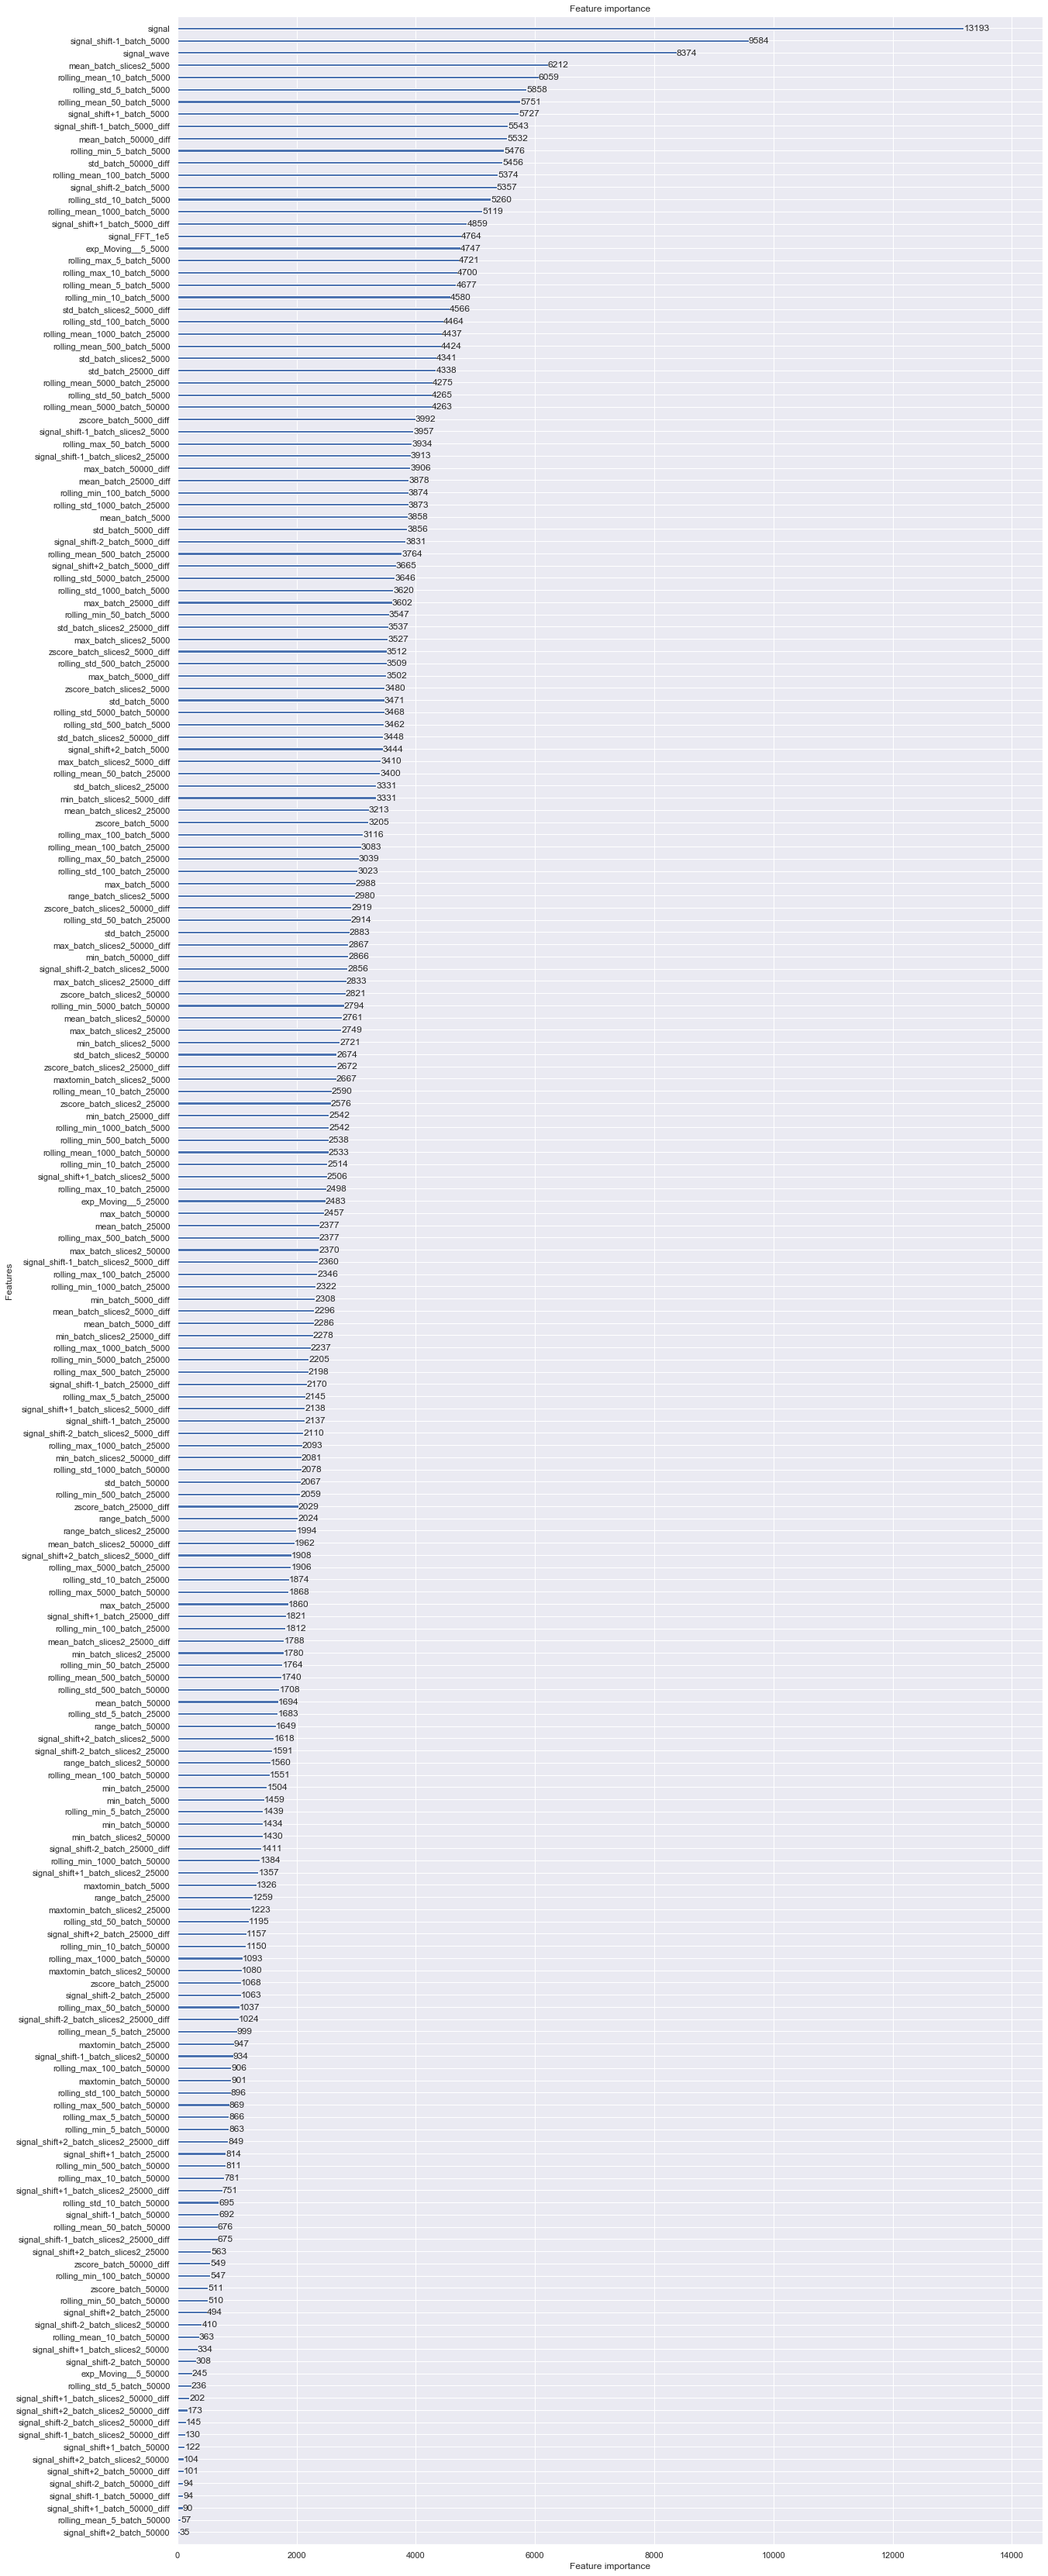

In [88]:
lgb.plot_importance(model,importance_type='split', max_num_features=300, figsize=(20, 60))